### 1. Описание набора данных

Набобор даных ```Fashion-MNIST``` содержит изображений одежды из каталога товаров компании Zalando.

### 2. Импорт библиотек

In [22]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import warnings
import urllib.request
import os
import zipfile

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

In [8]:
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib').setLevel(logging.ERROR)

### 3. Определение функций

In [52]:
def plot_data_multy(ax, ds, name=''):
  X, y = ds

  ax.set_title(name)

  for i in range(X.shape[0]):
    plt.text(X[i, 0], X[i, 1], str(y[i]),
      color=plt.cm.tab10((y[i]+0.5) /10 ),
      fontdict={'weight': 'bold', 'size': 9}
    )

  x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
  y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

  ax.set_xlim(x_min, x_max)
  ax.set_ylim(y_min, y_max)
  ax.set_xticks(())
  ax.set_yticks(())

In [111]:
def plot_clustering(X, hc, title, ax=None):
  """Визуализация результатов кластеризации
  Входные переменные:
  ===========
  X: данные, на которых мы хотим построить визуализацию
  hc: обученный класс Иерархической кластеризации
  """
  labels = hc.fit_predict(X)
  if ax is None:
    ax = plt.subplot(1, 1, 1)

  ax.scatter(
    X[:, 0],
    X[:, 1],
    c=labels,
    alpha=0.75,
    cmap='bwr',
    edgecolor='k',
    s=100
  )

  plt.xticks([],[])
  plt.yticks([],[])
  ax.set_title(title)

In [113]:
def plot_dendrogram(model, write_split, **kwargs):
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
      if child_idx < n_samples:
        current_count += 1
      else:
        current_count += counts[child_idx - n_samples]
    counts[i] = current_count

  linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
  ddata = dendrogram(linkage_matrix, **kwargs)

  plt.title('Дендрограмма иерархической кластеризации')
  plt.xlabel('индекс образца или (размер кластера)')
  plt.ylabel('расстояние')

  for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
    x = 0.5 * sum(i[1:3])
    y = d[1]
    if y > write_split:
      plt.plot(x, y, 'o', c=c)
      plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
        textcoords='offset points',
        va='top',
        ha='center'
      )

### 4. Загрузка данных

In [32]:
if not os.path.exists('data'):
  os.makedirs('data')

if not os.path.exists('data/fashion_mnist.zip'):
  urllib.request.urlretrieve('https://raw.githubusercontent.com/Losyash/mbml_II_hw/refs/heads/main/lab2/data/fashion_mnist.zip', 'data/fashion_mnist.zip')

if not os.path.exists('data/fashion_mnist.csv'):
  with zipfile.ZipFile('data/fashion_mnist.zip', 'r') as file:
    file.extractall('data')

In [33]:
df = pd.read_csv('data/fashion_mnist.csv')
df.head()

KeyboardInterrupt: 

In [26]:
X, y = df.drop('label', axis=1), df['label']

In [30]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,...,0.000000,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,0.0,...,0.011765,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [ ]:
X = X / 255.

In [16]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_part, y_part = X.values[:2500], y[:2500].astype(int).values

In [17]:
class_labels = {
  0: 'Футболка/топ',
  1: 'Брюки',
  2: 'Пуловер',
  3: 'Платье',
  4: 'Пальто',
  5: 'Сандалия',
  6: 'Рубашка',
  7: 'Кроссовки',
  8: 'Сумка',
  9: 'Ботильоны'
}

In [58]:
n_iter = 5000
perplexity = 10

tsne_10 = TSNE(
  n_components=2,
  verbose=0, 
  perplexity=perplexity,
  n_iter=n_iter,
  learning_rate='auto',
  init = 'pca'
)

tsne_10_results = tsne_10.fit_transform(X_part)

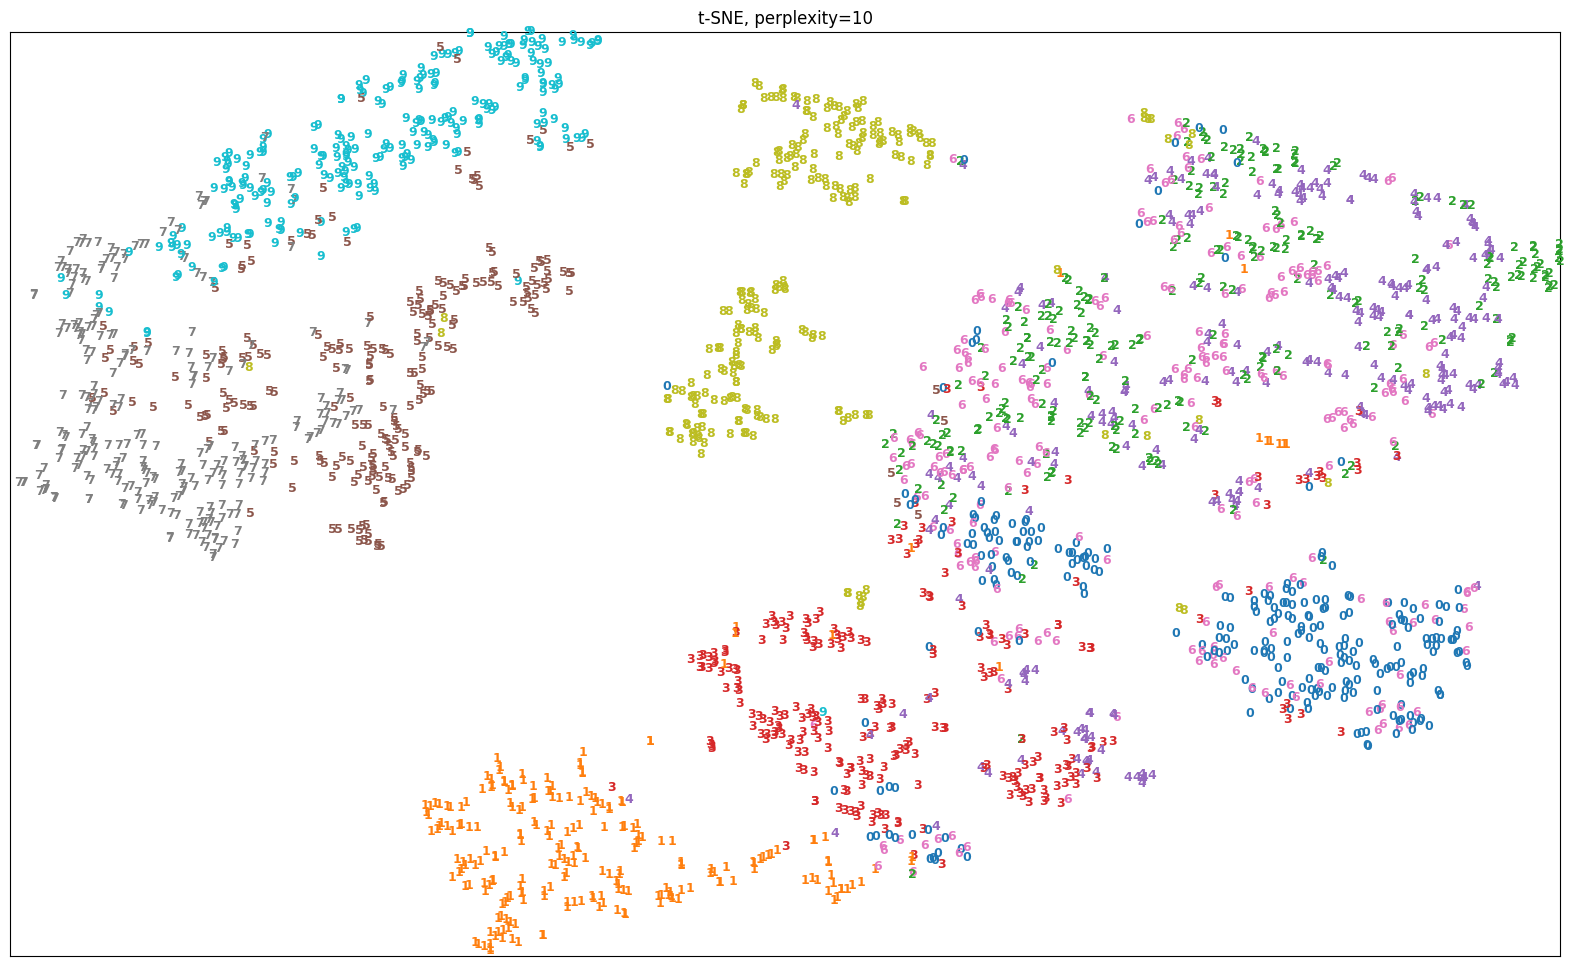

In [59]:
fig = plt.figure(figsize=(20, 12))
ax = plt.subplot(1, 1, 1)
plot_data_multy(ax, [tsne_10_results, y_part], 't-SNE, perplexity=10')

In [60]:
n_iter = 5000
perplexity = 30

tsne_30 = TSNE(
  n_components=2,
  verbose=0, 
  perplexity=perplexity,
  n_iter=n_iter,
  learning_rate='auto',
  init = 'pca'
)

tsne_30_results = tsne_30.fit_transform(X_part)

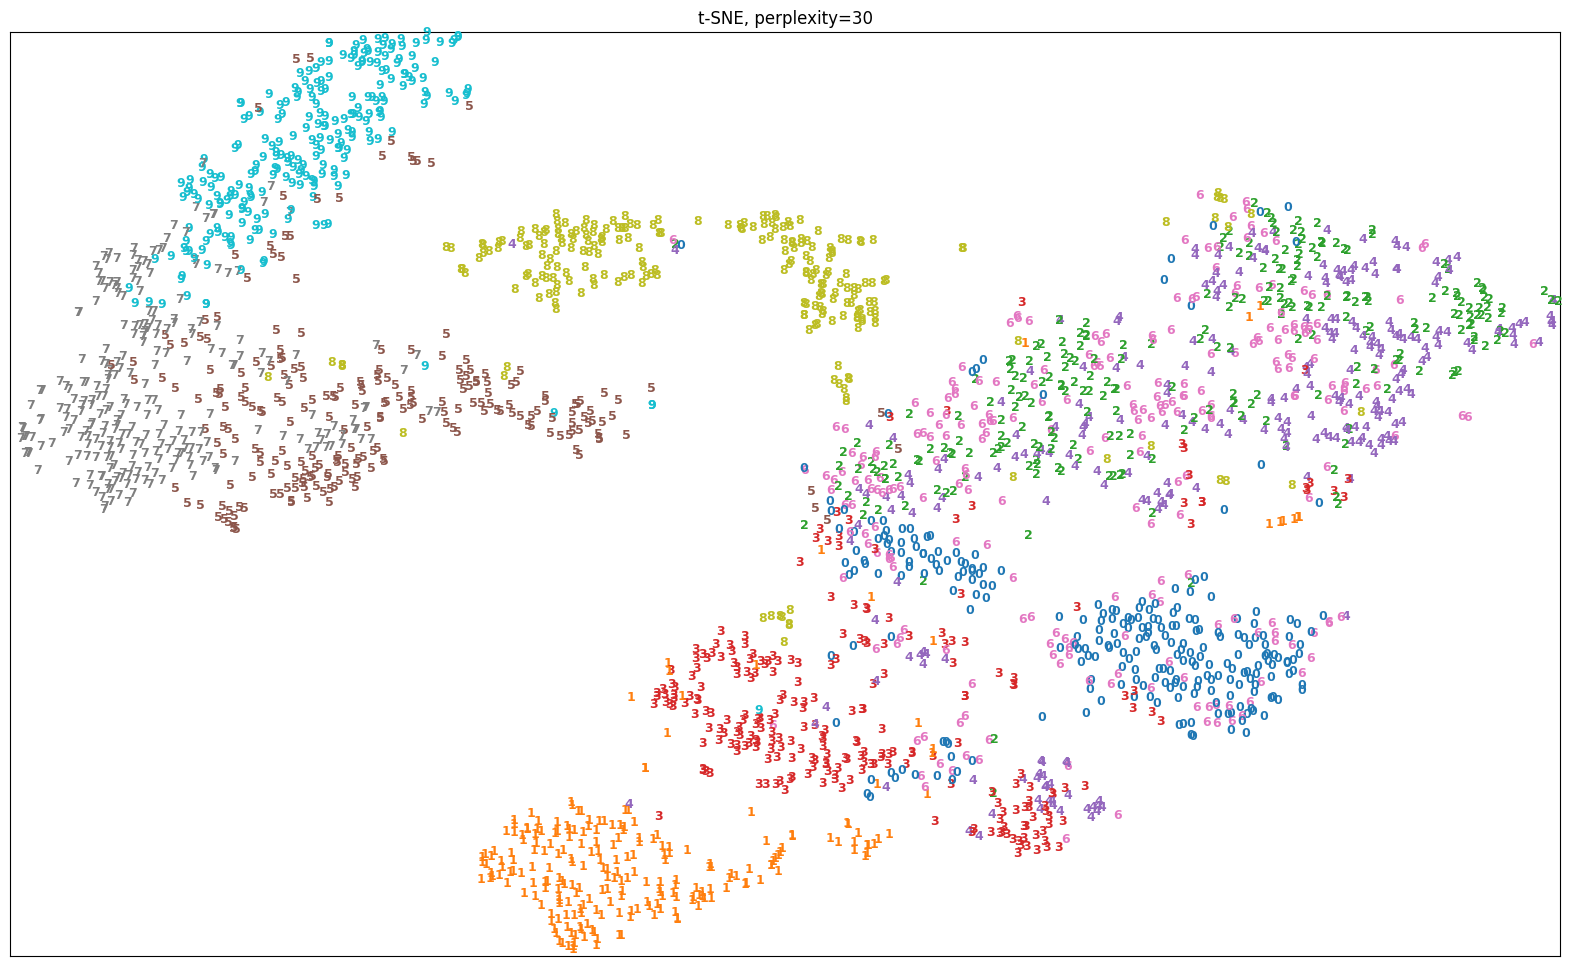

In [61]:
fig = plt.figure(figsize=(20, 12))
ax = plt.subplot(1, 1, 1)
plot_data_multy(ax, [tsne_30_results, y_part], 't-SNE, perplexity=30')

In [62]:
n_iter = 5000
perplexity = 50

tsne_50 = TSNE(
  n_components=2,
  verbose=0, 
  perplexity=perplexity,
  n_iter=n_iter,
  learning_rate='auto',
  init = 'pca'
)

tsne_50_results = tsne_50.fit_transform(X_part)

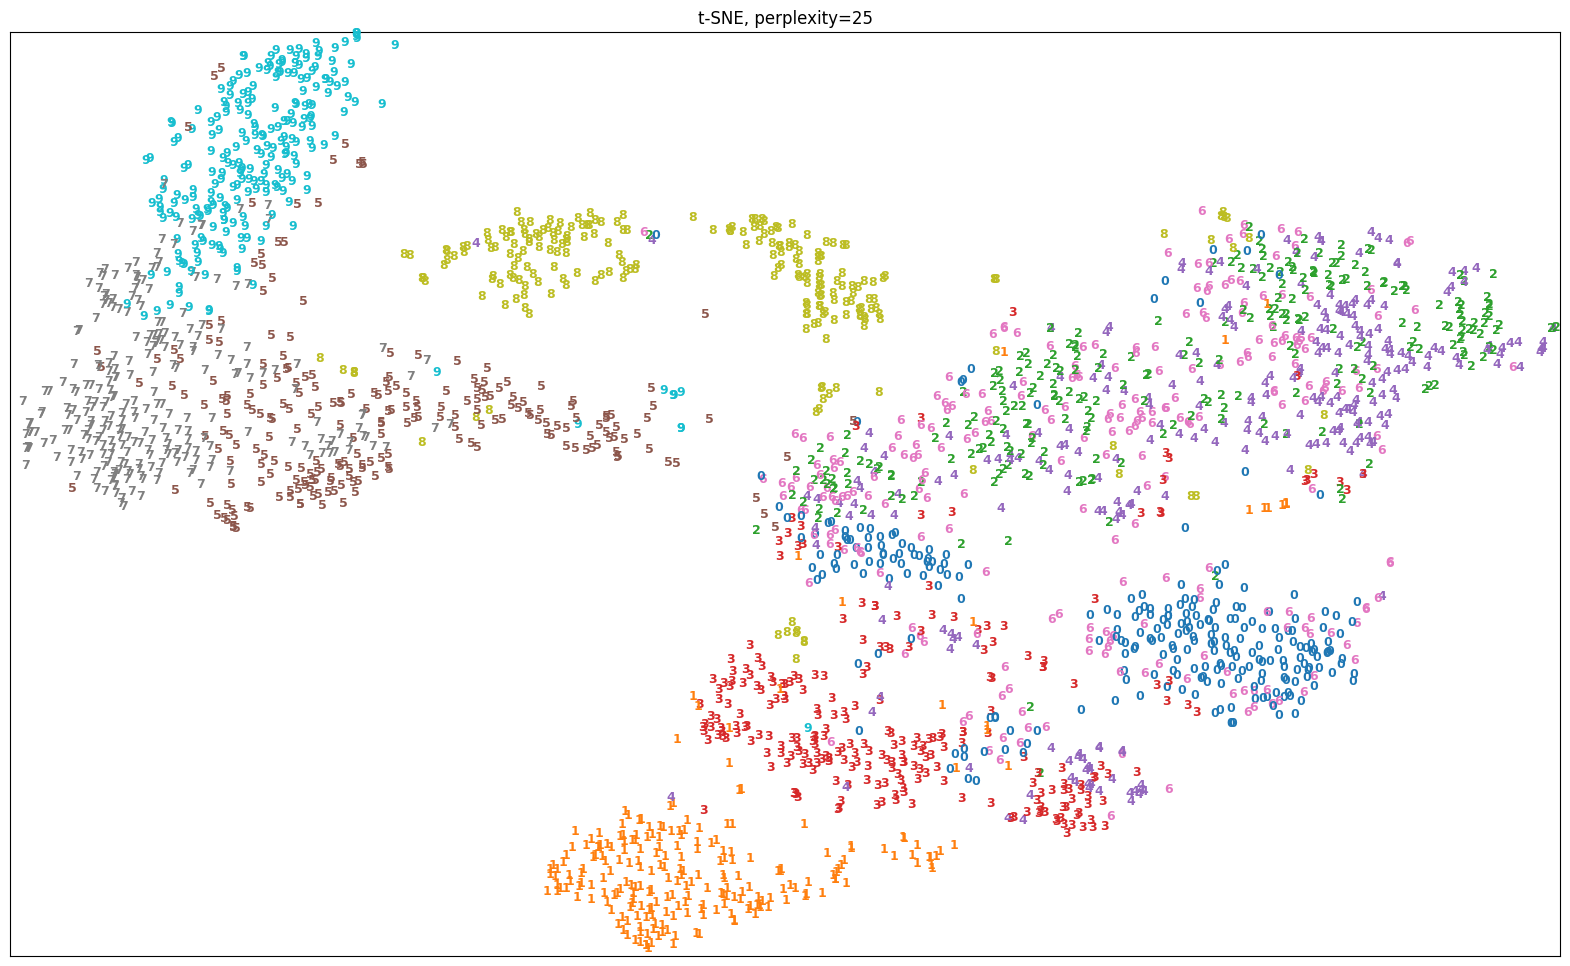

In [63]:
fig = plt.figure(figsize=(20, 12))
ax = plt.subplot(1, 1, 1)
plot_data_multy(ax, [tsne_50_results, y_part], 't-SNE, perplexity=25')

1. При значении `perplexity` 10:
    - Кластер 0 (футболки) разбит на два кластера по разные стороны от кластера 3 (платья).
    - Очень хорошо заметен кластер 1 (брюки).
    - Кластеры 2 (пуловеры), 4 (пальто), 6 (рубашки) представляют собой единый смешанный кластер.
    - Достаточно неплохо заметен кластер 3 (платья).
    - Можно отличить кластеры 5 (сандали), 7 (кроссовки), 9 (ботильоны), хотя они немного перемешаны. Отметим, что всё это обувь.
    - Достаточно явно - кластер 8 (сумки). Правда есть группа сумок, которая близка кластеру 3 (платья).
2. При увеличении значения `perplexity` до 30:
    - Кластер 0 (футболки) стал более заметен, и уже не разбит на два разных.
    - Всё также очень хорошо заметен кластер 1 (брюки).
    - Кластеры 2 (пуловеры), 4 (пальто), 6 (рубашки) остались представлять собой единый смешанный кластер.
    - Немного лучше стал заметен кластер 3 (платья).
    - Ситуация с кластерами 5 (сандали), 7 (кроссовки), 9 (ботильоны) заметно не изменилась.
    - Ситуация с кластером 8 (сумки) немного ухудшилась. К группе сумок, которая близка кластеру 3 (платья), добавилась небольшая группа близкая к 5 (сандалиям).
3. При дальнейшем увеличении значения `perplexity` до 50:
    - Кластер 0 (футболки) похоже стал еще немного более выделен.
    - Кластеры 2 (пуловеры), 4 (пальто), 6 (рубашки) так и не могут разделиться.
    - Остальное без видимых изменений.

In [64]:
df = pd.DataFrame(tsne_50_results, columns = ['t-SNE_1', 't-SNE_2'])
df['number'] = y_part.astype(str)

In [65]:
fig = px.scatter( 
  df,
  x='t-SNE_1', y='t-SNE_2',
  color = 'number',
  labels={'color': 'number'},
  hover_data=[df.index]
)

fig.update_layout(
  height=800,
  width=1400,
  template = "plotly_dark"
)

fig.update_traces(textposition='top center')
fig.show()

In [109]:
shady_figs = [ 170, 218, 347, 1519, 2244 ]

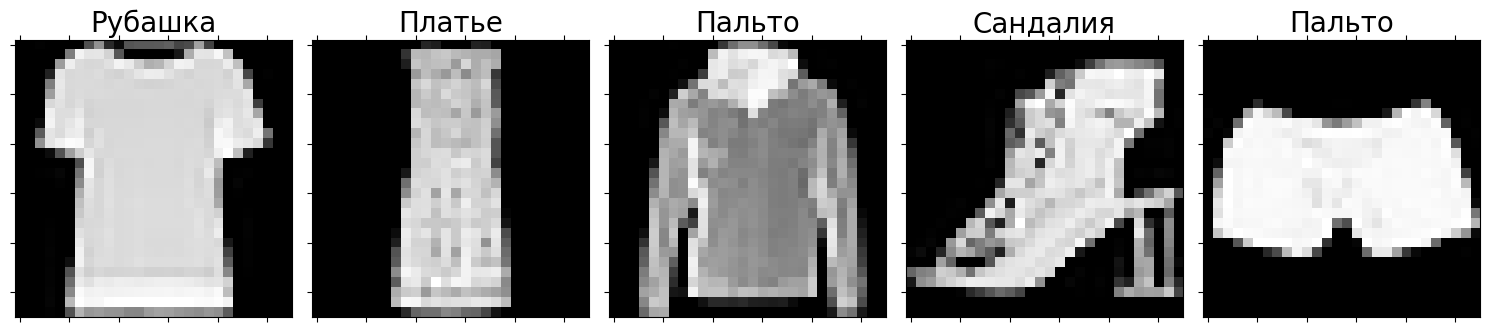

In [110]:
fig = plt.figure( figsize=(15,8) )

for n, i in enumerate(shady_figs):
  ax = fig.add_subplot(2,5,n+1)
  ax.set_title(class_labels[int(y[i])], size=20)

  ax.matshow(1 - X.loc[i,'pixel1':'pixel784'].values.reshape((28,28)).astype(float), cmap='Greys')

  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)
  plt.tight_layout()

Для кластеризации набора данных Fashion-MNIST, как и для любого другого, выбор метода зависит от данных.

- **EM-Кластеризация** подходит для данных с неизвестным количеством кластеров, но в данном случае количество классов известно и равно 10, что делает этот метод менее предпочтительным.

- **DBSCAN** хорошо подходит для данных с различной плотностью, но не всегда эффективен для задач кластеризации с известным количеством классов, так как он может не всегда корректно определять границы кластеров.

- **Иерархическая кластеризация** позволяет визуализировать структуру данных и выбрать оптимальное количество кластеров.

- **Спектральная кластеризация** использует собственные векторы матрицы смежности для кластеризации и может быть эффективной для данных с высокой размерностью, но в контексте Fashion-MNIST, где изображения уже сокращены до 28x28 пикселей, этот метод может не принести значительного улучшения.

Исходя из вышесказанного, **иерархическая кластеризация** может быть наиболее подходящим выбором для кластеризации набора данных Fashion-MNIST, так как она позволяет визуализировать структуру данных и выбрать оптимальное количество кластеров. Однако, хорошо бы, провести эксперименты с различными методами и гиперпараметрами, чтобы определить наилучший подход для конкретной задачи, но в рамках учебного домашнего задание этого делать не будем в виду ограниченности времени и ресурсов.

In [ ]:
Сначала создаем объект нужного класса, в котором можем изменять гиперпараметры.

В случае `иерархической кластеризации` в основном меняем:    
* `linkage` - тип связей (варианты  `'ward'`, `'average'`, `'complete'`, `'single'`),
* `n_clusters` - потенциальное число кластеров (в нашем случае 10),
* `distance_threshold` - порог по расстоянию (т.к. `n_clusters` задан, то указываем `None`),
* `compute_distances=True` - позволит вычислить расстояния между кластерами, даже если не используется порог по расстоянию.

In [ ]:
# Создаем класс иерархической кластеризации
hc_ward = AgglomerativeClustering(distance_threshold=None,
                                  compute_distances=True,
                                  n_clusters=10,
                                  linkage='ward')
# обучаем
hc_ward.fit(tsne_results_50)

hc_average = AgglomerativeClustering(distance_threshold=None,
                                     compute_distances=True,
                                     n_clusters=10,
                                     linkage='average')
hc_average.fit(tsne_results_50)

hc_complete = AgglomerativeClustering(distance_threshold=None,
                                      compute_distances=True,
                                      n_clusters=10,
                                      linkage='complete')
hc_complete.fit(tsne_results_50)

hc_single = AgglomerativeClustering(distance_threshold=None,
                             n_clusters=10,
                             linkage='single')
hc_single.fit(tsne_results_50);

In [ ]:
# Создаем сетку подграфиков размером 2x2
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Первый подграфик
plot_clustering(tsne_results_50, hc_ward, ax=axs[0, 0], title="linkage='ward'")

# Второй подграфик
plot_clustering(tsne_results_50, hc_average, ax=axs[0, 1], title="linkage='average'")

# Третий подграфик
plot_clustering(tsne_results_50, hc_complete, ax=axs[1, 0], title="linkage='complete'")

# Четвертый подграфик
plot_clustering(tsne_results_50, hc_single, ax=axs[1, 1], title="linkage='single'")

# Убираем лишние подписи осей
for ax in axs.flat:
    ax.label_outer()

plt.show()

Больше соответствует визуализации t-SNE иерархическая кластеризация с `linkage`: 'ward' и 'average'.

Основное различие в кластерах 5 (сандали), 7 (кроссовки), 9 (ботильоны). Но как вспомним, они довольно сильно пересекаются.

Результат иерархической кластеризация с `linkage`='ward', кажется наиболее подходящим.

In [ ]:
plt.figure(figsize=(15,4))
plot_dendrogram(hc_ward, write_split=1, truncate_mode='level', p=4)

In [ ]:
Когда есть дендрограмма, можно принимать решение о кластеризации с использованием порога по расстоянию.

Слегка модифицированный паттерн применения:

1. Создаем объект, в котором можем менять гиперпараметры

* `linkage` - берем тот же что и был при построения дендрограммы,
* `distance_threshold` - порог по расстоянию (из дендрограммы),
* `n_clusters` - потенциальное число кластеров (`None`, т.к. указываем `distance_threshold`, а одновременно указывать число кластеров и порог по расстоянию нельзя).

2. Обучаем методом `.fit()` (указываем только `X` - это же обучение без учителя).

3. Делаем предсказания - доступен `.fit_predict()` (т.е. **НЕЛЬЗЯ** подставлять новые данные).

4. Анализируем результат (в этом случае предлагается визуализация с подсцветкой).

In [ ]:
#@title Задание distance_threshold { run: "auto" }
#@markdown Можно писать число
dt = 140 #@param {type:"number"}


# создаем объект
hc = AgglomerativeClustering(distance_threshold=dt,
                                n_clusters=None,
                                linkage='ward')
# обучаем на данных
hc = hc.fit(tsne_results_50)

# предсказываем метки кластеров для данных
labels=hc.fit_predict(tsne_results_50)

# визуализируем с подкрашиванием
plt.figure(figsize=(5,5))
plt.scatter(tsne_results_50[:, 0], tsne_results_50[:, 1], cmap = 'bwr',
            c=labels, edgecolors = 'k',
             s=100)

n_clusters_ = hc.n_clusters_
plt.title('Предполагаемое количество кластеров: %d' % n_clusters_)
plt.xticks([],[])
plt.yticks([],[])
plt.grid()

Метод визуализации t-SNE смог выделить, можно считать, 7 отдельных групп данных из 10, которые заложены в датасет.

В нашем случае, использование t-SNE для визуализации данных Fashion-MNIST позволило увидеть какую-никакую структуру данных в двухмерном пространстве, что может быть полезно для понимания распределения различных типов одежды. Однако, важно помнить о возможных искажениях и неоднозначностях, которые могут возникнуть при интерпретации результатов t-SNE. Иерархическая кластеризация может дополнительно помочь в анализе данных, особенно если мы хотим увидеть иерархию кластеров, которые могут быть полезны для дальнейшего анализа или классификации данных.

Из решения о кластеризации с использованием порога по расстоянию более оптимальным выглядит деление на 7 кластеров.

Для оценки качества кластеров можно использовать критерий Силуэта. Этот критерий оценивает, насколько хорошо каждый объект соответствует своему кластеру по сравнению с другими кластерами.

In [ ]:
labels = hc_ward.fit_predict(tsne_results_50)
silhouette_avg = silhouette_score(tsne_results_50, labels)
print("Среднее значение критерия Силуэта: ", silhouette_avg)

Значение критерия Силуэта равное 0.4 указывает на среднюю степень сходства, которая ниже оптимального значения 1, но выше минимального значения -1. Это может указывать на то, что кластеры в наборе данных имеют некоторую степень разделения, но и есть области перекрытия. Это нормально в случаях, когда данные имеют сложную структуру.